### 1 . Thực hiện với data after_preprocess_no_categorical.csv

In [1]:
import pandas as pd

df_no = pd.read_csv("../data/after_preprocess_no_categorical.csv")

df_no.head()

,BMI,Weight (kg),Calories,Height (m),Burns Calories (per 30 min),Water_Intake (liters),Fat_Percentage
0,-0.007712,-0.407549,-0.403077,-0.811571,-0.045632,-1.864510,26.800377
1,-0.215145,-0.826017,-0.825681,-1.362623,0.408037,-1.203034,27.655021
2,-0.562857,-0.704633,-0.768472,-0.417962,0.484893,-1.236108,24.320821
3,1.123469,0.939010,1.167388,-0.181796,0.236589,-0.210821,32.813572
4,-1.506005,-1.014469,-1.023142,1.235196,-0.456983,0.467191,17.307319


Chọn random_state = 15 vì ngày thực hiện là ngày 15

In [2]:
from sklearn.model_selection import train_test_split

X = df_no.drop("Fat_Percentage", axis=1)
y = df_no['Fat_Percentage']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15
) 

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

r_train = []
mse_train = []

r_test = []
mse_test = []

order = [i+1 for i in range(5)]
for i in tqdm(order):
    model = Pipeline(steps=[
            ("poly", PolynomialFeatures(degree=i, include_bias=False)),
            ("reg", LinearRegression())
        ])
    
    model.fit(x_train, y_train)
    r_train.append(model.score(x_train, y_train))
    r_test.append(model.score(x_test, y_test))

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    mse_train.append(mean_squared_error(y_pred_train, y_train))
    mse_test.append(mean_squared_error(y_pred_test, y_test))

100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


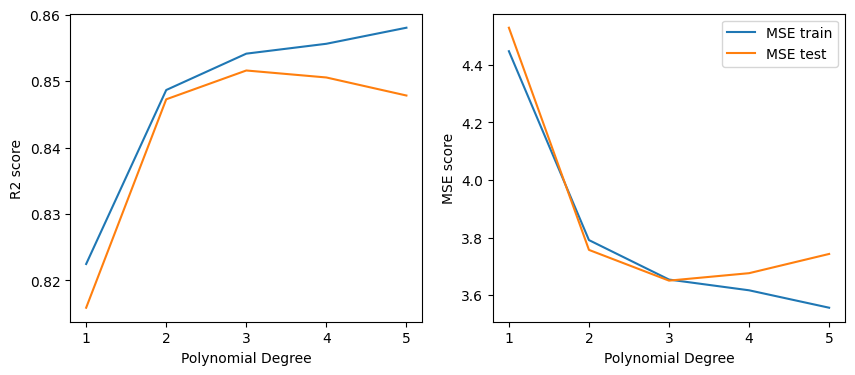

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(order, r_train, label='R2 train')
ax[0].plot(order, r_test, label='R2 test')
ax[0].set_xlabel('Polynomial Degree')
ax[0].set_ylabel('R2 score')

ax[1].plot(order, mse_train, label='MSE train')
ax[1].plot(order, mse_test, label='MSE test')
ax[1].set_xlabel('Polynomial Degree')
ax[1].set_ylabel('MSE score')

plt.legend()

Nhìn vào hình trên có thể thấy rằng bậc tốt nhất cho bài toán này là bậc 3

In [5]:
model = Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
        ("reg", LinearRegression())
    ])

model.fit(x_train, y_train)

print("\nIntercept (w0):", model.named_steps["reg"].intercept_)
print("\nCoefficients (w1..wm):")
print(model.named_steps["reg"].coef_)


Intercept (w0): 26.338912801927698

Coefficients (w1..wm):
[-1.87732990e+01  2.67258076e+01 -8.66084813e-01 -1.32222189e+01
  1.41418627e-01 -8.58890073e-02 -2.86251870e+01  4.55223429e+01
  6.22379227e+00 -1.54247916e+01  9.42941908e+00  3.04446145e+01
 -1.59361171e+01 -7.37672010e+00  4.51839870e+00 -9.80054446e+00
 -3.22313416e+01  4.24648540e-01  3.46657296e+00 -1.55691662e-01
 -1.51067767e-01  1.41233934e+00  5.23784177e+00  1.66802360e+01
  3.06889279e-02 -2.96693309e-02 -1.22346443e-02 -4.11165798e+00
  1.37220684e+01 -1.78232422e-01 -1.31410620e+01  9.39035984e-01
  2.22286658e+00 -1.86582939e+01  5.56858842e+00  2.17169340e+01
 -1.32484691e+00 -5.48159112e+00 -2.44217833e+00  1.34516475e+00
 -5.00930124e-01  7.47229637e-01 -6.73667815e+00  2.19011315e+00
  6.22984484e+00  1.10635393e-01 -2.43318483e-01  1.54519599e-01
  7.43109558e+00 -9.85555716e-01 -1.23183188e+01  3.50835705e-01
  2.88476273e+00 -2.38275906e+00  2.92216284e+00  3.84029729e-01
  1.04325835e-01  6.99452270e+

Thực hiện cross-validation

In [6]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=15)

r2_scores = []

for train_idx, val_idx in kf.split(X):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    r2_scores.append(model.score(X_val, y_val))

print("R2 score từng fold:", r2_scores)
print("R2 score trung bình:", np.mean(r2_scores))

R2 score từng fold: [0.8516011260616819, 0.8577161834894662, 0.8513608685151113, 0.8518197209644791, 0.8504623579137547]
R2 score trung bình: 0.8525920513888987


In [7]:
r2_scores = pd.Series(r2_scores)
print("Độ lệch chuẩn : ", r2_scores.std())
print("Trung bình : ", r2_scores.mean())

Độ lệch chuẩn :  0.002910608297222793
Trung bình :  0.8525920513888987


### 2 . Thực hiện với data after_preprocess_with_categorical.csv

In [8]:
df_with = pd.read_csv("../data/after_preprocess_with_categorical.csv")

df_with.head()

,BMI,Weight (kg),Calories,Height (m),Burns Calories (per 30 min),Water_Intake (liters),Gender,Difficulty Level,Burns_Calories_Bin,ohe__Workout_Type_Cardio,...,pull-up bar,barbell,low bar,trx,bench,sturdy surface,kettlebell,platform,dumbbell,Fat_Percentage
0,-0.007712,-0.407549,-0.403077,-0.811571,-0.045632,-1.864510,1,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,26.800377
1,-0.215145,-0.826017,-0.825681,-1.362623,0.408037,-1.203034,0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,27.655021
2,-0.562857,-0.704633,-0.768472,-0.417962,0.484893,-1.236108,0,1.0,2.0,1.0,...,0,0,0,0,0,0,0,0,0,24.320821
3,1.123469,0.939010,1.167388,-0.181796,0.236589,-0.210821,0,2.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,32.813572
4,-1.506005,-1.014469,-1.023142,1.235196,-0.456983,0.467191,1,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,17.307319


In [9]:
X = df_with.drop("Fat_Percentage", axis=1)
y = df_with['Fat_Percentage']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15
) 

In [10]:
r_train = []
mse_train = []

r_test = []
mse_test = []

order = [i+1 for i in range(2)]
for i in tqdm(order):
    model = Pipeline(steps=[
            ("poly", PolynomialFeatures(degree=i, include_bias=False)),
            ("reg", LinearRegression())
        ])
    
    model.fit(x_train, y_train)
    r_train.append(model.score(x_train, y_train))
    r_test.append(model.score(x_test, y_test))

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    mse_train.append(mean_squared_error(y_pred_train, y_train))
    mse_test.append(mean_squared_error(y_pred_test, y_test))

100%|██████████| 2/2 [00:23<00:00, 11.64s/it]


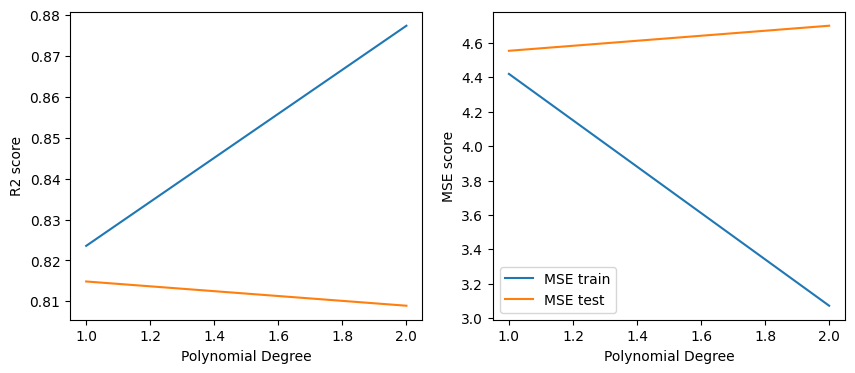

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(order, r_train, label='R2 train')
ax[0].plot(order, r_test, label='R2 test')
ax[0].set_xlabel('Polynomial Degree')
ax[0].set_ylabel('R2 score')

ax[1].plot(order, mse_train, label='MSE train')
ax[1].plot(order, mse_test, label='MSE test')
ax[1].set_xlabel('Polynomial Degree')
ax[1].set_ylabel('MSE score')

plt.legend()

Nhìn vào hình trên có thể thấy rằng bậc tốt nhất cho bài toán này là bậc 1

In [12]:
model = Pipeline(steps=[
        ("poly", PolynomialFeatures(degree=1, include_bias=False)),
        ("reg", LinearRegression())
    ])

model.fit(x_train, y_train)

print("\nIntercept (w0):", model.named_steps["reg"].intercept_)
print("\nCoefficients (w1..wm):")
print(model.named_steps["reg"].coef_)


Intercept (w0): 26.368368004126793

Coefficients (w1..wm):
[ 1.28371621e+00  3.70778214e+00 -2.60544118e-01 -1.78127434e+00
  4.35865976e-02  2.58204642e-03 -2.29082616e-02 -1.37793968e-03
 -6.31187411e-02 -3.17053491e-02 -5.98260066e-02  7.25538631e-02
  1.89774927e-02  3.53122815e-02 -1.59640960e-02 -3.80200673e-02
  1.86718817e-02  1.03099704e-01  5.30950294e-02 -5.67134344e-02
 -2.22255822e-02  1.16377029e-04 -7.73720940e-02 -2.35057135e-03
  3.14879918e-03  6.04059329e-02 -2.94987536e-02 -7.60009826e-02
 -2.81597653e-02  7.24553407e-02  1.05435378e-02  1.38604246e-02
 -2.48499739e-02  8.32628465e-03 -3.10121263e-02  1.03403614e-02
  1.27914918e-02 -6.28604775e-03  2.30190634e-02  8.81017331e-02
 -4.53430353e-02 -4.23141134e-02  8.86560217e-03  5.42597151e-02
 -3.55084777e-02  3.64311630e-02  1.67449133e-02 -4.89524081e-02
 -8.53623176e-02  3.63442098e-02  8.36500896e-03 -7.33502772e-02
  1.94709770e-03  6.60817993e-02  8.86559881e-02 -1.15988030e-01
 -1.04711222e-01  2.07267652e-

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

r2_scores = []

for train_idx, val_idx in kf.split(X):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]
    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    r2_scores.append(model.score(X_val, y_val))

print("R2 score từng fold:", r2_scores)
print("R2 score trung bình:", np.mean(r2_scores))

R2 score từng fold: [0.8148565454016237, 0.8253312303541168, 0.8215660315544558, 0.8207067110222156, 0.8190840069448728]
R2 score trung bình: 0.8203089050554571


### Nhận xét : 

    - Đúng như khi EDA thì khi thêm các biến categorical không hề khiến mô hình dự đoán tốt hơn mà còn giảm điểm R2.
    - Về kết quả của cross-validation thì ...